# Testing automatic fiducial finding

We want to automatically find fiducials and spit out an ANC file for work with peak selector

In [1]:
%matplotlib inline
import pandas as pd
import tqdm
import numpy as np
from skimage.filters import threshold_otsu
%load_ext autoreload
%autoreload 2
import palm_utils as pu
from peaks.peakfinder import PeakFinder

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm

In [25]:
data = pu.PALMData("//nrs/hess/Cryo/20170519/PALM4K_Cell7/Run1_532/Part1/PALM_data_IDL.sav")

Reading //nrs/hess/Cryo/20170519/PALM4K_Cell7/Run1_532/Part1/PALM_data_IDL.sav into memory ... 


C:\Anaconda3\lib\site-packages\scipy\io\idl.py:473: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


--------------------------------------------------
Date: Sun Aug  6 01:46:07 2017
User: hoffmand
Host: h11u19.int.janelia.org
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 29 records of which:
 - 1 are of type TIMESTAMP
 - 26 are of type VARIABLE
 - 1 are of type VERSION
--------------------------------------------------
Available variables:
 - nmperframe [<class 'numpy.float32'>]
 - wfilename [<class 'str'>]
 - totalrawdata [<class 'numpy.ndarray'>]
 - grouping_gap [<class 'numpy.int16'>]
 - z_unwrap_coeff [<class 'numpy.ndarray'>]
 - lambda_vac [<class 'numpy.float32'>]
 - pkwidth_offset [<class 'numpy.float32'>]
 - cgrpsize [<class 'numpy.int16'>]
 - rawfilenames [<class 'numpy.ndarray'>]
 - nd_water [<class 'numpy.float32'>]
 - grouping_radius100 [<class 'numpy.int16'>]
 - image [<class 'numpy.ndarray'>]
 - fliprotate [<class 'numpy.re

In [4]:
def find_fiducials(df, yx_shape, subsampling=1, thresh=None):
    """Find fiducials in pointilist PALM data
    
    The key here is to realize that there should be on fiducial per frame"""
    # incase we subsample the frame number
    num_frames = df.framenum.max() - df.framenum.min()
    bins = [np.arange(s + subsampling, step=subsampling) - subsampling / 2 for s in yx_shape]
    # ungrouped 2d histogram to find peaks, ungrouped to make beads really stand out
    hist_2d = np.histogramdd(df[["ypos", "xpos"]].values, bins=bins)[0]
    pf = PeakFinder(hist_2d, 1)
    # set the thresh to 1/10th of the number of frames (if this doesn't work drift is really bad)
#     pf.thresh = num_frames * min(subsampling, 1) * 0.12 
    # the 0.12 factor is for the DoG filter for blob finding.
    pf.blob_sigma = 1/subsampling
    # no blobs found so try again with a lower threshold
    pf.thresh = 0
    pf.find_blobs()
    blob_thresh = max(threshold_otsu(pf.blobs[:, 3]), num_frames / 10)
    if not pf.blobs.size:
        # still no blobs then raise error
        raise RuntimeError("No blobs found!")
    pf.blobs = pf.blobs[pf.blobs[:,3] > blob_thresh]
#     pf.plot_blobs(cmap="inferno", norm=PowerNorm(0.5))
    if pf.blobs[:, 3].max() < num_frames * subsampling / 2:
        print("Warning, drift maybe too high to find fiducials")
    # correct positions for subsampling
    pf.blobs[:, :2] = pf.blobs[:, :2] * subsampling
    return pf.blobs

In [5]:
# This one doesn't work nearly as well

# from skimage.feature.peak import peak_local_max
# def find_fiducials(df, yx_shape, subsampling=1, thresh=None):
#     """Find fiducials in pointilist PALM data
    
#     The key here is to realize that there should be on fiducial per frame"""
#     # incase we subsample the frame number
#     num_frames = df.framenum.max() - df.framenum.min()
#     # we want the bins to be centered around a given pixel.
#     bins = [np.arange(s + subsampling, step=subsampling) - subsampling / 2 for s in yx_shape]
#     # ungrouped 2d histogram to find peaks, ungrouped to make beads really stand out
#     hist2d, edges = np.histogramdd(df[["ypos", "xpos"]].values, bins=bins)
#     # threshold and find localmaxima
#     if thresh is None:
#         thresh = num_frames
#     for thresh in np.linspace(0, thresh, 10)[::-1]:
#         fiducial_locations = peak_local_max(hist2d, threshold_abs=thresh)
#         if fiducial_locations.size:
#             break
#     amps = hist2d[fiducial_locations[:,0], fiducial_locations[:,1]]
#     amps.shape = (-1, 1)
#     return np.hstack((fiducial_locations, np.ones_like(amps), amps))

In [6]:
junk = find_fiducials(data.processed, (832,)*2)

In [7]:
junk[:, 3]

array([ 8273.,  7867.,  7843., ...,  3330.,  3290.,  3221.])

# Refining

We can see that we pick too many fiducials above, we should drift correct and then test again

In [8]:
def remove_xy_mean(df):
    df_mean = df[["ypos", "xpos"]].astype(np.float).mean()
    df_new = df.copy()
    df_new[["ypos", "xpos"]] -= df_mean
    return df_new

def calc_drift(fiducials_df, weighted="amp", diagnostics=False):
    """"""
    mean_removed = [remove_xy_mean(ff) for ff in fiducials_df]
    if diagnostics:
        fig, (ax0, ax1) = plt.subplots(1, 2)
        for ff in mean_removed:
            ff.xpos.plot(ax=ax0)
            ff.ypos.plot(ax=ax1)
            
    # want to do a weighted average
    # need to reset_index after concatination so that all localzations have unique ID
    df_means = pd.concat(mean_removed).reset_index()

    # Define a dictionary with the functions to apply for a given column:
    if weighted:
        wm = lambda group: np.average(group, weights=df_means.loc[group.index, weighted])
    else:
        wm = "mean"
    return df_means.groupby("framenum").agg({"xpos" : wm, "ypos" : wm})

In [9]:
def calc_fiducial_stats(fid_df_list):
    """Calculate various stats"""
    fwhm = lambda x: x.std() * 2 * np.sqrt(2 * np.log(2))
    fid_stats = pd.DataFrame([f[["xpos", "ypos", "amp"]].mean() for f in fid_df_list])
    fid_stats[["xdrift", "ydrift"]] = pd.DataFrame([f.agg({"xpos":fwhm,"ypos":fwhm}) for
                                                    f in fid_df_list])
    fid_stats["sigma"] = np.sqrt(fid_stats.ydrift**2 + fid_stats.xdrift**2)
    all_drift = pd.concat([f[["xpos","ypos"]] - f[["xpos","ypos"]].mean() for f in fid_df_list])
    return fid_stats, all_drift

def extract_fiducials(df, blobs, radius, min_num_frames=0):
    """Do the actual filtering
    
    We're doing it sequentially because we may run out of memory.
    If initial DataFrame is 18 GB (1 GB per column) and we have 200 """
    fiducials_dfs = [df[np.sqrt((df.xpos - x) ** 2 + (df.ypos - y) ** 2) < radius]
        for y, x in tqdm.tqdm_notebook(blobs, leave=False, desc="Extracting Fiducials")]
    # remove any duplicates in a given frame by only keeping the localization with the largest count
    clean_fiducials = [sub_df.sort_values('amp', ascending=False).groupby('framenum').first()
                       for sub_df in fiducials_dfs if len(sub_df) > min_num_frames]
    return clean_fiducials

In [27]:
def drift_correct_sub(df_data, data_shape, *, num_peaks=None, minamp=0, fids=None, min_num_frames=0, radius=None):
    if fids is None:
        fids = find_fiducials(df_data, data_shape, thresh=min_num_frames)
    # this is kludgy
    peak_s = slice(num_peaks)
    radius2 = 5
    if min_num_frames:
        # check for number of frames (this is by histogram)
        s = fids[:, 3] > min_num_frames
        radius2 = 1
    else:
        s = slice(None)
        
    if radius is not None:
        radius2 = radius
    if minamp:
        # take a small sample to calculate amp from
        fids_df_init = extract_fiducials(df_data[df_data.framenum < df_data.framenum.min() + 10], fids[:,:2], radius2, 0)
        fids_init = pd.DataFrame([f.mean() for f in fids_df_init])
        fids_init = fids_init[fids_init.amp > minamp]
        fids_df = extract_fiducials(df_data, fids_init[["ypos", "xpos"]].values[peak_s], radius2, min_num_frames)
    else:
        fids_df = extract_fiducials(df_data, fids[s][peak_s,:2], radius2, min_num_frames)
    drift_mean = calc_drift(fids_df, False)
    drift_mean.plot()
    df_data_dc = df_data.set_index("framenum")
    df_data_dc[["xpos", "ypos"]] -= drift_mean
    return df_data_dc.reset_index(), drift_mean, fids_df

def drift_correct_iter(df_data, data_shape, iters, minamp, num_peaks):
    """Just an iteration version"""
    # initial drift correction on 10 only
    df_data_dc, drift_mean, fids_df = drift_correct_sub(df_data, data_shape, num_peaks=10, minamp=minamp)
    num_frames = df_data.framenum.max() - df_data.framenum.min()
    for i in range(iters - 1):
        # radius should be decreasing on each iteration.
        df_data_dc, drift_mean_sub, fids_df = drift_correct_sub(df_data_dc, data_shape, num_peaks=num_peaks, min_num_frames=num_frames, minamp=minamp)
        drift_mean += drift_mean_sub
        if (drift_mean_sub.dropna() < 0.0001).values.all():
            print("no change")
            break
            
    # final extraction of fiducials for drift analysis
    fid_stats, _ = calc_fiducial_stats(fids_df)
    fids=fid_stats[["ypos", "xpos"]].values
    fids_df = extract_fiducials(df_data_dc, fids, 1)
    return df_data_dc, drift_mean, fids_df

In [28]:
data_short = data.processed[data.processed.framenum < 100000]

Warning, drift maybe too high to find fiducials


no change


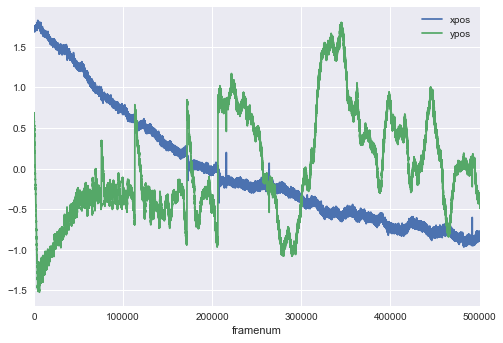

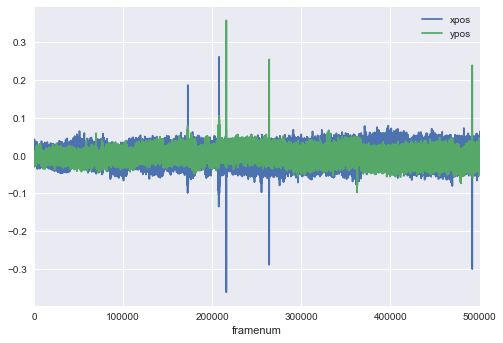

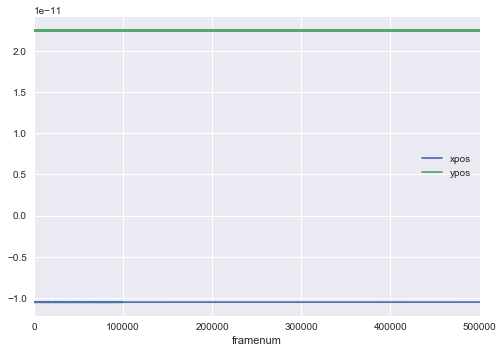

In [43]:
df_data_dc, drift_mean, fids_df = drift_correct_iter(data.processed, (832, ) * 2, 20, 2000, num_peaks=None)

xpos    5.380011
ypos    4.396385
dtype: float64

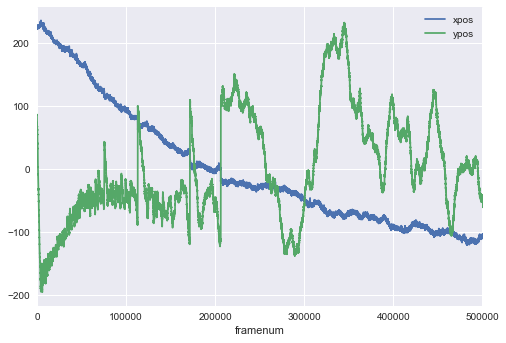

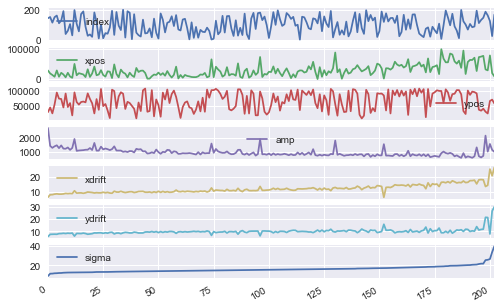

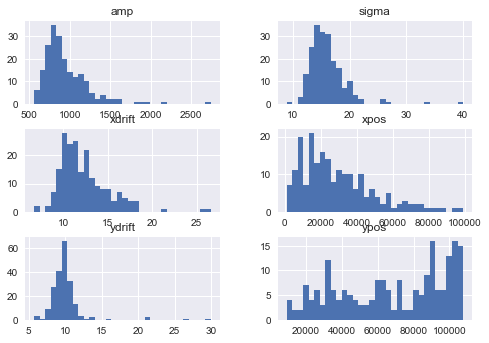

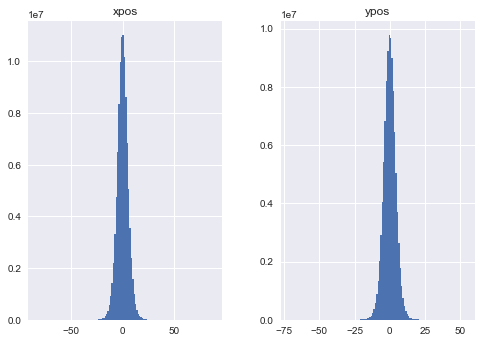

In [44]:
(drift_mean * 130).plot()
junk_fid, junk_drift = calc_fiducial_stats(fids_df)
junk_drift *= 130
junk_fid[["xpos", "xdrift", "ypos", "ydrift", "sigma"]] *= 130
junk_fid.sort_values("sigma").reset_index().plot(subplots=True)
junk_fid.hist(bins=32)
junk_drift.hist(bins=128)
junk_drift.std()

Basic heuristic is this:
1. take initial data, make histogram with camera pixel sizes
1. find the first ten potential fiducials and drift correct on them
1. find all fiducials that meet user determined criteria: min average amplitude and min number of frames
1. drift correct on all of those fiducials
1. calculate residual drift on each fiducial
1. find all fiducials which have a residual drift which is less than `drift.mean() + drift.std()`
1. drift correct on those setting the search radius to `drift.mean() + drift.std() * 3`

In [45]:
def drift_correct2(df_data, data_shape, *, minamp=0, min_num_frames=0, max_fids=None):
    """Just an iteration version"""
    # initial drift correction on 10 only, steps 1 and 2
    df_data_dc, drift_mean, fids_df = drift_correct_sub(df_data, data_shape, num_peaks=10, minamp=minamp)
    # steps 3 and 4
    df_data_dc, drift_mean_sub, fids_df = drift_correct_sub(df_data_dc, data_shape, min_num_frames=min_num_frames, minamp=minamp)
    drift_mean += drift_mean_sub
    # step 5
    fid_stats, _ = calc_fiducial_stats(fids_df)
    # step 6
    fid_filt = fid_stats[fid_stats.sigma < fid_stats.sigma.min() + fid_stats.sigma.std()]
    # step 7
    new_radius = fid_stats.sigma.min() + fid_stats.sigma.std() * 3
    fids=fid_filt[["ypos", "xpos"]].values[slice(max_fids)]
    print("drift correcting on filtered fiducials")
    df_data_dc, drift_mean_sub, fids_df = drift_correct_sub(df_data_dc, data_shape, fids=fids)
    drift_mean += drift_mean_sub
    # final extraction of fiducials for drift analysis
    fids_df = extract_fiducials(df_data_dc, fids, new_radius)
    fid_stats.info()
    fid_filt.info()
    print(fids.shape)
    return df_data_dc, drift_mean, fids_df

Warning, drift maybe too high to find fiducials


drift correcting on filtered fiducials


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 6 columns):
xpos      561 non-null float64
ypos      561 non-null float64
amp       561 non-null float64
xdrift    561 non-null float64
ydrift    561 non-null float64
sigma     561 non-null float64
dtypes: float64(6)
memory usage: 26.4 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 0 to 559
Data columns (total 6 columns):
xpos      450 non-null float64
ypos      450 non-null float64
amp       450 non-null float64
xdrift    450 non-null float64
ydrift    450 non-null float64
sigma     450 non-null float64
dtypes: float64(6)
memory usage: 24.6 KB
(15, 2)


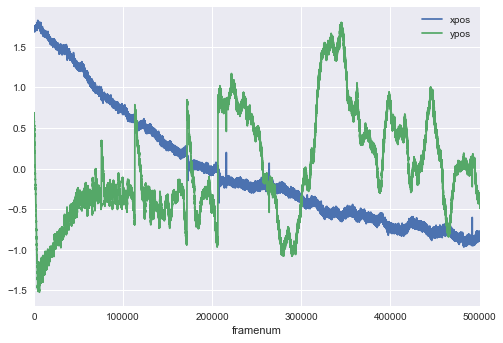

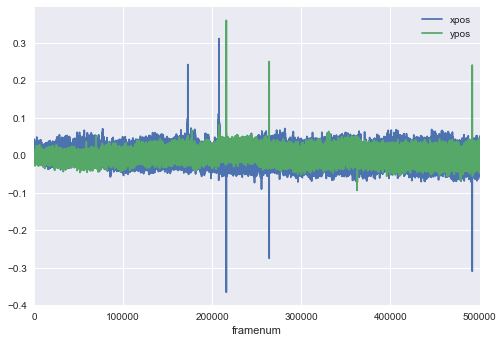

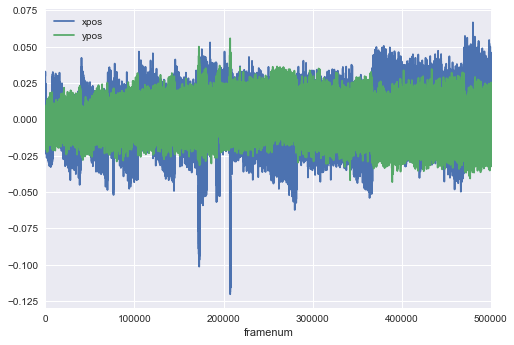

In [46]:
df_data_dc2, drift_mean2, fids_df2 = drift_correct2(data.processed, (832, ) * 2, min_num_frames=1000, minamp=2000, max_fids=15)

xpos    4.761466
ypos    3.939944
dtype: float64

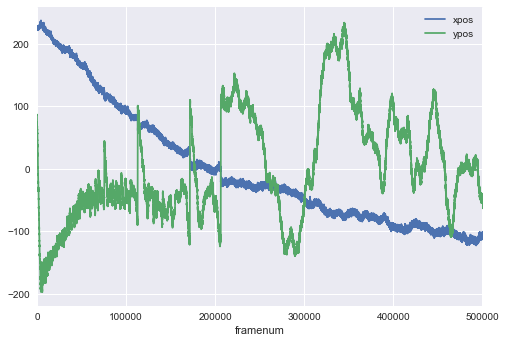

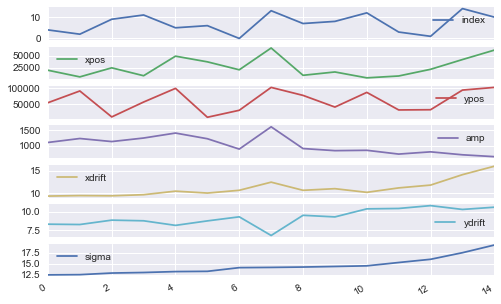

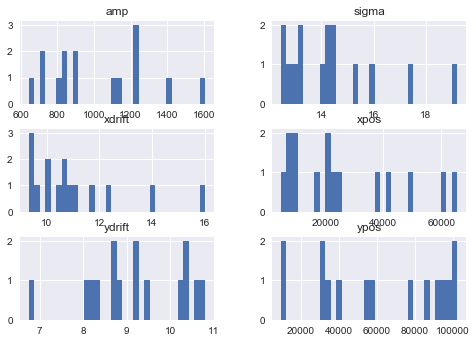

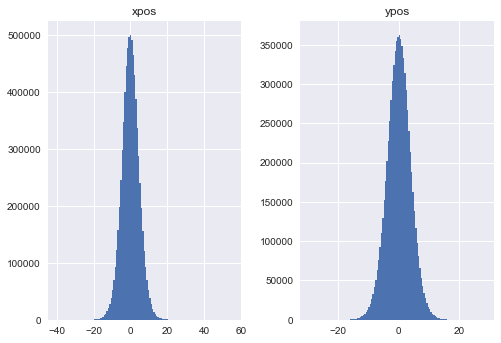

In [47]:
(drift_mean2 * 130).plot()
junk2_fid, junk2_drift = calc_fiducial_stats(fids_df2)
junk2_drift *= 130
junk2_fid[["xpos", "xdrift", "ypos", "ydrift", "sigma"]] *= 130
junk2_fid.sort_values("sigma").reset_index().plot(subplots=True)
junk2_fid.hist(bins=32)
junk2_drift.hist(bins=128)
junk2_drift.std()

In [48]:
fids_tosave, fids_tosave_drift = calc_fiducial_stats(fids_df2)
tosave = np.zeros((500, 6))
tosave[:len(fids_tosave), :2] = (fids_tosave[["xpos", "ypos"]].values)
np.savetxt("Run1_532_Fid.anc", tosave, '%08.8g', delimiter=" " * 7)

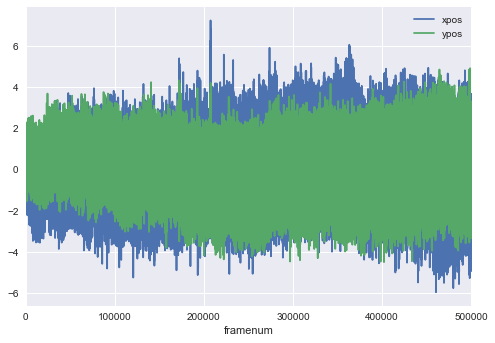

In [49]:
((drift_mean - drift_mean2) * 130).plot()

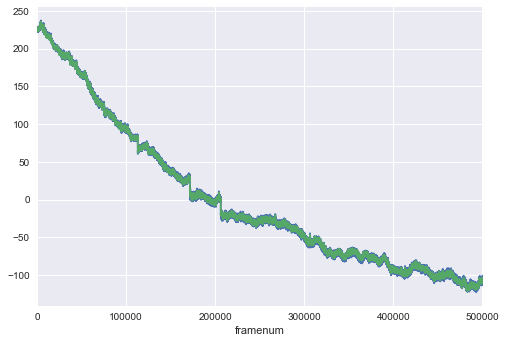

In [50]:
(drift_mean2.xpos * 130).plot()
(drift_mean.xpos * 130).plot()

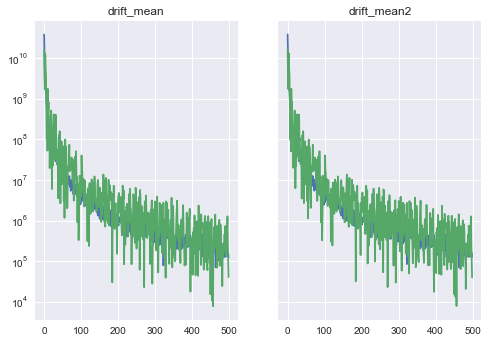

In [51]:
fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, sharey=True)
ax0.semilogy(abs((np.fft.fft(drift_mean, axis=0)[1:500])**2))
ax1.semilogy(abs((np.fft.fft(drift_mean2, axis=0)[1:500])**2))
ax0.set_title("drift_mean")
ax1.set_title("drift_mean2")

## Cross validate

In [52]:
fids_df1 = extract_fiducials(df_data_dc, fids_tosave[["ypos", "xpos"]].values, 1)
fids_df2 = extract_fiducials(df_data_dc2, fids_tosave[["ypos", "xpos"]].values, 1)

In [57]:
def plot_stats(fids_df):
    fid, drift = calc_fiducial_stats(fids_df)
    drift *= 130
    fid[["xpos", "xdrift", "ypos", "ydrift", "sigma"]] *= 130
    fid.sort_values("sigma").reset_index().plot(subplots=True)
    fid.hist(bins=32)
    drift.hist(bins=64, normed=True)
    print(drift.std())

xpos    4.913420
ypos    4.067981
dtype: float64


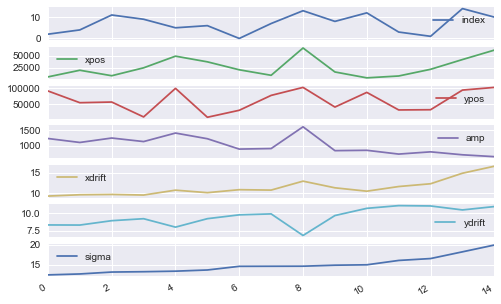

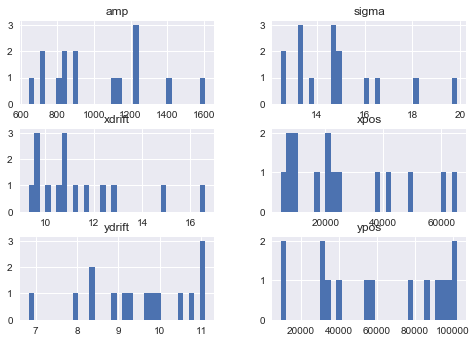

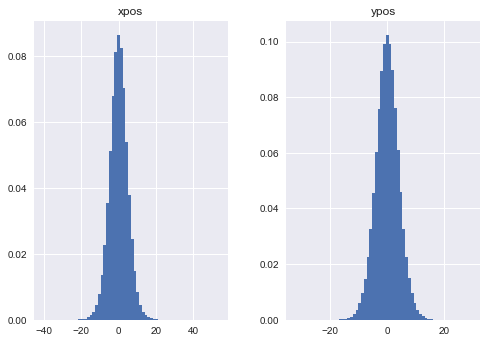

In [59]:
plot_stats(fids_df1)

xpos    4.761466
ypos    3.939944
dtype: float64


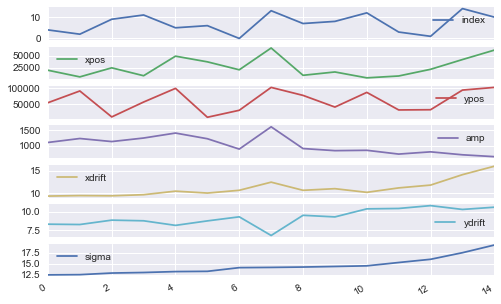

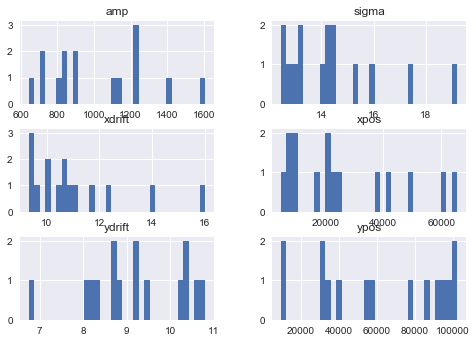

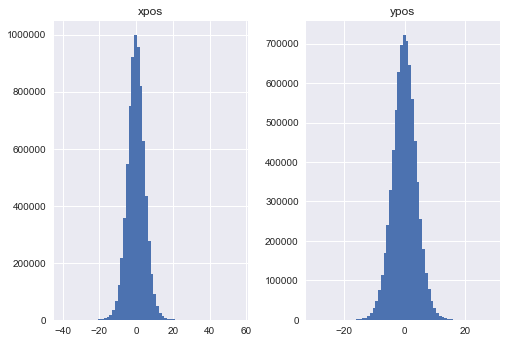

In [55]:
plot_stats(fids_df2)

In [81]:
for junk in fids_df1:
    r = junk.rolling(100, center=True,min_periods=1).mean()
    print((r.max() - r.min())[["xpos", "ypos"]] * 130)

xpos    10.432314
ypos    13.225086
dtype: float64
xpos    20.421709
ypos    12.829670
dtype: float64
xpos    14.731829
ypos    13.723859
dtype: float64
xpos    17.984277
ypos    11.741867
dtype: float64
xpos    10.705332
ypos     9.091242
dtype: float64
xpos    23.636591
ypos    17.581434
dtype: float64
xpos    10.050677
ypos    23.094566
dtype: float64
xpos    10.534358
ypos    13.850007
dtype: float64
xpos    9.018861
ypos    9.992671
dtype: float64
xpos    13.628658
ypos    21.369189
dtype: float64
xpos    35.800840
ypos    21.089015
dtype: float64
xpos    15.734677
ypos    12.808870
dtype: float64
xpos    14.653228
ypos    17.739966
dtype: float64
xpos    23.754429
ypos     9.869157
dtype: float64
xpos    15.619642
ypos    14.988412
dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023CCEF23898>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000023CE1DAB320>]], dtype=object)

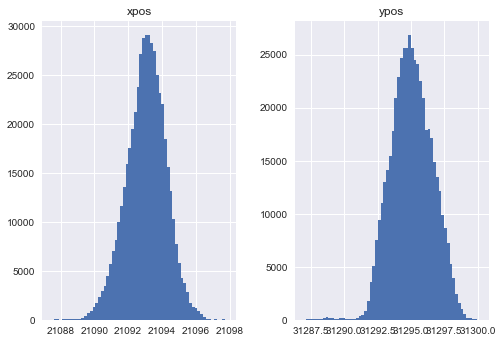

In [79]:
(r[["xpos", "ypos"]] * 130).hist(bins=64)

In [80]:
(r[["xpos", "ypos"]] * 130).std() * 2*np.sqrt(2*np.log(2))

xpos    2.759402
ypos    3.638250
dtype: float64